#**Analysis of the weather from Brazil in the year 2021:**

## Description of the dataset chosen and the questions that will be answered:

### **Dataset:**

The dataset that will be used is one from the **Instituto Nacional de Metereologia (INMET)**, that is an institute from Brazil with weather information.
Here is the website: https://portal.inmet.gov.br/

There is an API available to capture weather data at various formats and periods.
Here is a manual to understand how to use this API:
https://portal.inmet.gov.br/manual/manual-de-uso-da-api-esta%C3%A7%C3%B5es


### **Goal:**

The goal of this project is to answer some questions about the behaviour of the weather in Brazil, based on historical data extracted from **INMET**.
The questions are formulated in a way so that the answers provide different features in Python used by Data Scientists.

Here are the questions:


1.   Which state was the driest (with the least accumulated rain) on the year of 2021? And the one with the most rain? Are they on the same or different regions from Brazil (North, South, Northeast, etc)?
2.   How is the average temperature for each state, month by month, on the year 2021?
3.   What is the relationship between rain and temperature, considering the average from all Brazilian states? These variables are correlated somehow?



---

## Beginning of the code section:

### All necessary libraries are reunited on the cell below for better organization:

In [1]:
# libraries for basic data manipulation:
import numpy as np
import pandas as pd

# libraries to make plots and visualizations:
import seaborn as sns
import matplotlib.pyplot as plt

# libraries to extract and manipulate data from APIs:
import json
import requests

# library to work with dates and times:
import datetime as dt

### All necessary functions created are declared on the cell below:

In [60]:

# function to get a list of station names:
def get_stations_list(station_type):
  
    url = 'https://apitempo.inmet.gov.br/estacoes/{}'.format(station_type)
    response = requests.get(url)

    status = response.status_code
    print('Request status: {}'.format(status))

    result = response.text #[1:-1]
    json_dict = json.loads(result)

    df_stations = pd.json_normalize(json_dict)

    return df_stations


# function to get historical weather data per station:
def get_historical_data_per_station(initial_date, end_date, station_code):

  url = 'https://apitempo.inmet.gov.br/estacao/diaria/{}/{}/{}'.format(initial_date, end_date, station_code)

  response = requests.get(url)
  status = response.status_code

  df_per_station = pd.json_normalize(json.loads(response.text))

  return df_per_station


# function to get all historical weather data of every station:
def get_all_historical_data(df_stations, initial_date, end_date):

  df_historical = pd.DataFrame()
  for idx, row in df_stations.iterrows():
    station_code = row['CD_ESTACAO']
    df_temp = get_historical_data_per_station(initial_date, end_date, station_code)

    df_historical = pd.concat([df_historical, df_temp], ignore_index=True)

  return df_historical

# function to plot the average temperature by month for the state given
def plot_monthly_average_temperature(state, column_name='avg_temperature'):

  df_temp = df_historical.query("state == '{}'".format(state))

  df_avg_temperature = df_temp.groupby('month', as_index=False).agg({
    'avg_temperature': ['mean', 'median', 'min', 'max']
  })

  df_avg_temperature.columns = df_avg_temperature.columns.droplevel(0)
  df_avg_temperature.columns = ['month', 'avg_temperature', 'median_temperature', 'min_temperature', 'max_temperature']

  plt.figure(figsize=(12, 4))
  plt.plot(df_avg_temperature['month'], df_avg_temperature[column_name]);
  
  plt.title(state)
  plt.show()


### 1 - Obtaining the dataset to use on the rest of the code:

- Get the list of all automatic stations;
- Get all historical data for each station and put everything on the same dataframe

In [5]:
# station_type = 'T' (using only automatic stations):

# salving the dataset on a pandas dataframe:
df_stations = get_stations_list('T')

# each row on the dataset is a weather station somewhere in Brazil:
df_stations.head()

Request status: 200


,CD_OSCAR,DC_NOME,FL_CAPITAL,DT_FIM_OPERACAO,CD_SITUACAO,TP_ESTACAO,VL_LATITUDE,CD_WSI,CD_DISTRITO,VL_ALTITUDE,SG_ESTADO,SG_ENTIDADE,CD_ESTACAO,VL_LONGITUDE,DT_INICIO_OPERACAO
0,0-2000-0-86765,ABROLHOS,N,None,Pane,Automatica,-17.96305555,0-76-0-2906907000000408,04,20.93,BA,INMET,A422,-38.70333333,2008-07-20T21:00:00.000-03:00
1,0-2000-0-81755,ACARAU,N,None,Pane,Automatica,-3.1211111,0-76-0-2300200000000446,03,67.15,CE,INMET,A360,-40.08722221,2009-04-21T21:00:00.000-03:00
2,0-2000-0-86827,AFONSO CLAUDIO,None,None,Pane,Automatica,-20.10416666,0-76-0-3200102000000478,06,507.48,ES,INMET,A657,-41.10694444,2011-09-23T21:00:00.000-03:00
3,0-2000-0-86686,AGUA BOA,N,None,Pane,Automatica,-14.01638888,0-76-0-5100201000000157,09,440,MT,INMET,A908,-52.21166666,2006-12-15T21:00:00.000-03:00
4,0-2000-0-86812,AGUA CLARA,N,None,Operante,Automatica,-20.44444444,0-76-0-5000203000000463,07,323.63,MS,INMET,A756,-52.87583332,2010-08-13T21:00:00.000-03:00


In [6]:
# checking how many stations there are:
df_stations.shape

# There are 607 weather stations in Brazil:

(607, 15)

In [8]:
# considering only the stations that are working (CD_SITUACAO = Operante)
# translation of the status (PT -> EN):
# - Operante = Functioning
# - Pane = Defect / Mal-functioning

df_stations = df_stations.query("CD_SITUACAO == 'Operante' ")
df_stations.shape

# But only 400 of the 607 weather stations in Brazil are functioning:

(400, 15)

In [9]:
# checking how many stations per state:
df_stations['SG_ESTADO'].value_counts(dropna=False).head()

# There are 42 weather stations in Sao Paulo (SP), where I live:

MG    63
RS    41
BA    30
GO    26
RJ    26
Name: SG_ESTADO, dtype: int64

In [11]:
df_stations.isnull().sum()

# no null values in any of the important columns!!

CD_OSCAR               58
DC_NOME                 0
FL_CAPITAL             58
DT_FIM_OPERACAO       400
CD_SITUACAO             0
TP_ESTACAO              0
VL_LATITUDE             0
CD_WSI                 32
CD_DISTRITO             0
VL_ALTITUDE            18
SG_ESTADO               0
SG_ENTIDADE             0
CD_ESTACAO              0
VL_LONGITUDE            0
DT_INICIO_OPERACAO      0
dtype: int64

In [12]:
# getting historical weather data from every station for the whole year of 2021:

print('Start: {}'.format(dt.datetime.now()))
initial_date = '2021-01-01'
end_date = '2021-12-31'

df_historical = get_all_historical_data(df_stations, initial_date, end_date)
print(df_historical.shape)

print('End: {}'.format(dt.datetime.now()))

Start: 2022-02-15 23:27:27.254119
(146000, 13)
End: 2022-02-15 23:34:44.250242


In [10]:
df_historical.head()

,UMID_MED,DT_MEDICAO,DC_NOME,UMID_MIN,TEMP_MED,CHUVA,VL_LATITUDE,TEMP_MIN,TEMP_MAX,UF,VEL_VENTO_MED,CD_ESTACAO,VL_LONGITUDE
0,85,2021-01-01,ÁGUA CLARA,55,24.9,14.8,-20.44444444,21.6,31.5,MS,1.4,A756,-52.87583332
1,70.3,2021-01-02,ÁGUA CLARA,31,27.5,3.2,-20.44444444,20.9,35.7,MS,1,A756,-52.87583332
2,63.6,2021-01-03,ÁGUA CLARA,27,28.4,0,-20.44444444,20.8,36,MS,1.1,A756,-52.87583332
3,72.5,2021-01-04,ÁGUA CLARA,48,26.4,0,-20.44444444,23.3,33.2,MS,1.9,A756,-52.87583332
4,76.8,2021-01-05,ÁGUA CLARA,47,26.2,1.4,-20.44444444,21.7,33.3,MS,1.6,A756,-52.87583332


### 2 - Preparing the dataset:

- Rename the columns and remove the ones not needed;
- Adjust the data types of each column, if necessary;
- Check for missing values;

In [13]:
# which columns will be needed?
df_historical.columns

Index(['UMID_MED', 'DT_MEDICAO', 'DC_NOME', 'UMID_MIN', 'TEMP_MED', 'CHUVA',
       'VL_LATITUDE', 'TEMP_MIN', 'TEMP_MAX', 'UF', 'VEL_VENTO_MED',
       'CD_ESTACAO', 'VL_LONGITUDE'],
      dtype='object')

In [14]:
# DT_MEDICAO = measure_date
# CD_ESTACAO = weather_station_code
# DC_NOME = weather_station_name
# UF = state
# CHUVA = rain_precipitation
# TEMP_MED = avg_temperature
# TEMP_MIN = min_temperature
# TEMP_MAX = max_temperature
original_cols = ['DT_MEDICAO', 'CD_ESTACAO', 'DC_NOME', 'UF', 'CHUVA', 'TEMP_MED', 'TEMP_MIN', 'TEMP_MAX']

translated_cols = [
    'measure_date', 'weather_station_code', 'weather_station_name', 'state', 
    'rain_precipitation', 'avg_temperature', 'min_temperature', 'max_temperature'
]

df_historical = df_historical[original_cols]
df_historical.columns = translated_cols

df_historical.head()

,measure_date,weather_station_code,weather_station_name,state,rain_precipitation,avg_temperature,min_temperature,max_temperature
0,2021-01-01,A756,ÁGUA CLARA,MS,14.8,24.9,21.6,31.5
1,2021-01-02,A756,ÁGUA CLARA,MS,3.2,27.5,20.9,35.7
2,2021-01-03,A756,ÁGUA CLARA,MS,0,28.4,20.8,36
3,2021-01-04,A756,ÁGUA CLARA,MS,0,26.4,23.3,33.2
4,2021-01-05,A756,ÁGUA CLARA,MS,1.4,26.2,21.7,33.3


In [15]:
# what are the best data types for each column?
df_historical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146000 entries, 0 to 145999
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   measure_date          146000 non-null  object
 1   weather_station_code  146000 non-null  object
 2   weather_station_name  146000 non-null  object
 3   state                 146000 non-null  object
 4   rain_precipitation    90770 non-null   object
 5   avg_temperature       99739 non-null   object
 6   min_temperature       106347 non-null  object
 7   max_temperature       106122 non-null  object
dtypes: object(8)
memory usage: 8.9+ MB


In [16]:
# forcing all quantitative variables to a float number:
df_historical['rain_precipitation'] = df_historical['rain_precipitation'].astype(float)
df_historical['avg_temperature'] = df_historical['avg_temperature'].astype(float)
df_historical['min_temperature'] = df_historical['min_temperature'].astype(float)
df_historical['max_temperature'] = df_historical['max_temperature'].astype(float)

# changing the date variable to timestamp type:
df_historical['measure_date'] = pd.to_datetime(df_historical['measure_date'])

In [17]:
# checking the data types again to make sure the data type adjustments worked:
df_historical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146000 entries, 0 to 145999
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   measure_date          146000 non-null  datetime64[ns]
 1   weather_station_code  146000 non-null  object        
 2   weather_station_name  146000 non-null  object        
 3   state                 146000 non-null  object        
 4   rain_precipitation    90770 non-null   float64       
 5   avg_temperature       99739 non-null   float64       
 6   min_temperature       106347 non-null  float64       
 7   max_temperature       106122 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(3)
memory usage: 8.9+ MB


In [18]:
# are there any missing values?
df_historical.isnull().sum()

# yes, there are a lot of missing values on the columns with sensor data (rain, temperature, humidity, etc)!!

measure_date                0
weather_station_code        0
weather_station_name        0
state                       0
rain_precipitation      55230
avg_temperature         46261
min_temperature         39653
max_temperature         39878
dtype: int64

In [19]:
df_historical[df_historical['rain_precipitation'].isnull()]['weather_station_name'].value_counts(dropna=False)

# there are a lot of stations without any information about the rain...

DTCEA GUAJARA-MIRIM                      365
DTCEA TABATINGA                          365
DTCEA JACAREACANGA                       365
PEF IPIRANGA                             365
CAMPO VERDE                              365
                                        ... 
CALDAS                                     1
RESENDE                                    1
SÃO JOAQUIM                                1
BOM JARDIM DA SERRA - MORRO DA IGREJA      1
MARIA DA FÉ                                1
Name: weather_station_name, Length: 347, dtype: int64

### 3 - Exploratory Data Analysis (EDA) + Answer for the questions:

#### Answering question 1:
- Which state was the driest (with the least accumulated rain) on the year of 2021? 
- And the one with the most rain? 
- Are they on the same or different regions from Brazil (North, South, Northeast, etc)?

In [20]:
# checking rain precipitation per state:
df_precipitation_per_state = df_historical.groupby('state', as_index=False).agg({
    'weather_station_code': ['count', 'nunique'],
    'measure_date': ['min', 'max', 'nunique'],
    'rain_precipitation': ['sum', 'mean', 'median', 'min', 'max']
})

df_precipitation_per_state.columns = df_precipitation_per_state.columns.droplevel(0)
df_precipitation_per_state.columns = ['state', 'num_measures', 'unique_stations', 'min_date', 'max_date', 'distinct_dates',
                                      'total_precipitation', 'avg_precipitation', 'median_precipitation', 'min_precipitation', 'max_precipitation']

df_precipitation_per_state.head()

,state,num_measures,unique_stations,min_date,max_date,distinct_dates,total_precipitation,avg_precipitation,median_precipitation,min_precipitation,max_precipitation
0,AC,365,1,2021-01-01,2021-12-31,365,2381.4,7.108657,0.2,0.0,184.0
1,AL,1095,3,2021-01-01,2021-12-31,365,795.0,1.652807,0.0,0.0,58.8
2,AM,5110,14,2021-01-01,2021-12-31,365,6896.0,7.036735,0.4,0.0,159.8
3,BA,10950,30,2021-01-01,2021-12-31,365,20957.0,3.896077,0.0,0.0,160.8
4,CE,2190,6,2021-01-01,2021-12-31,365,3208.4,2.437994,0.0,0.0,102.6


In [27]:
# answering the first question:
df_precipitation_per_state.sort_values(by=['avg_precipitation'], ascending=True).head(1)

# State with least rain, on average: PE (Pernambuco)

,state,num_measures,unique_stations,min_date,max_date,distinct_dates,total_precipitation,avg_precipitation,median_precipitation,min_precipitation,max_precipitation
14,PE,1825,5,2021-01-01,2021-12-31,365,1314.8,1.245076,0.0,0.0,66.8


In [31]:
# answering the first question:
df_precipitation_per_state.sort_values(by=['avg_precipitation'], ascending=False).head(1)

# State with most rain, on average: AC (Acre)

,state,num_measures,unique_stations,min_date,max_date,distinct_dates,total_precipitation,avg_precipitation,median_precipitation,min_precipitation,max_precipitation
0,AC,365,1,2021-01-01,2021-12-31,365,2381.4,7.108657,0.2,0.0,184.0


**Answer for question 1:**
- The "driest" state is Pernambuco;
- The rainest state is Acre;
- They are located on different regions from Brazil, Pernambuco at the Northeast region and Acre at the North region. 

#### Answering question 2:
- How is the average temperature for each state, month by month, on the year 2021?

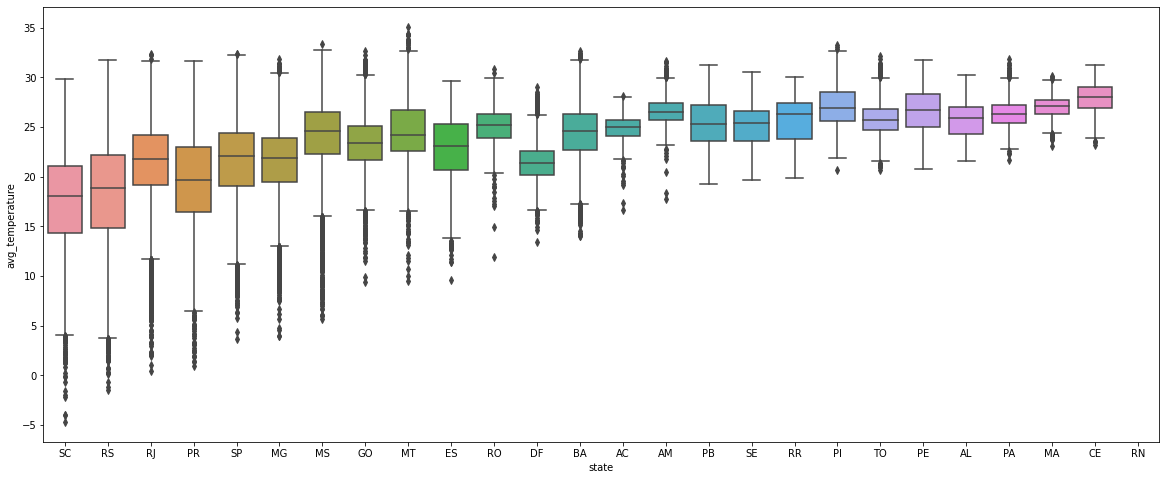

In [34]:
# checking the distribution of the temperature each day per state using a boxplot:
plt.figure(figsize=(20,8));
sns.boxplot(data=df_historical.sort_values('avg_temperature'), x='state', y='avg_temperature');
plt.show()

# Median temperature ranges from approximately 18 degrees (on SC - Santa Catarina) to almost 30 degrees (on CE - Ceara)

In [38]:
# checking the temperature per state, numerically:
df_temperature = df_historical.groupby('state', as_index=False).agg({
    'measure_date': ['count', 'nunique', 'min', 'max'],
    'weather_station_code': ['nunique'],
    'avg_temperature': ['mean', 'median', 'min', 'max']
})

df_temperature.columns = df_temperature.columns.droplevel(0)
df_temperature.columns = ['state', 'num_measures', 'num_days', 
                                'min_date', 'max_date', 'num_stations',
                                'avg_temperature', 'median_temperature', 'min_temperature', 'max_temperature']

df_temperature.head()

,state,num_measures,num_days,min_date,max_date,num_stations,avg_temperature,median_temperature,min_temperature,max_temperature
0,AC,365,365,2021-01-01,2021-12-31,1,24.819940,25.0,16.6,28.1
1,AL,1095,365,2021-01-01,2021-12-31,3,25.722412,25.9,21.6,30.2
2,AM,5110,365,2021-01-01,2021-12-31,14,26.579361,26.5,17.8,31.6
3,BA,10950,365,2021-01-01,2021-12-31,30,24.350882,24.6,14.0,32.7
4,CE,2190,365,2021-01-01,2021-12-31,6,27.895476,28.0,23.2,31.2


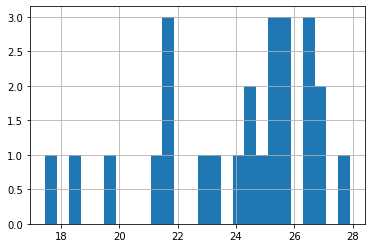

In [51]:
# plotting a histogram with one bin per state (26 states) to see the distribution of the temperature:
df_temperature['avg_temperature'].hist(bins=26);

# Conclusion: Brazil is indeed a tropical country (most states with high average temperature)

In [52]:
# now answering question 2:

# creating a column with the month of the measurement:
df_historical['month'] = df_historical['measure_date'].dt.month
df_historical['month'] = df_historical['month'].astype(int)

df_historical.head()

,measure_date,weather_station_code,weather_station_name,state,rain_precipitation,avg_temperature,min_temperature,max_temperature,month
0,2021-01-01,A756,ÁGUA CLARA,MS,14.8,24.9,21.6,31.5,1
1,2021-01-02,A756,ÁGUA CLARA,MS,3.2,27.5,20.9,35.7,1
2,2021-01-03,A756,ÁGUA CLARA,MS,0.0,28.4,20.8,36.0,1
3,2021-01-04,A756,ÁGUA CLARA,MS,0.0,26.4,23.3,33.2,1
4,2021-01-05,A756,ÁGUA CLARA,MS,1.4,26.2,21.7,33.3,1


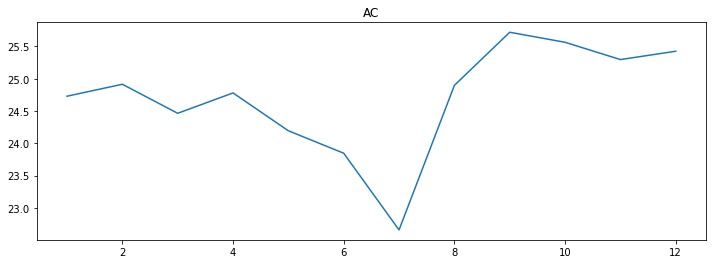

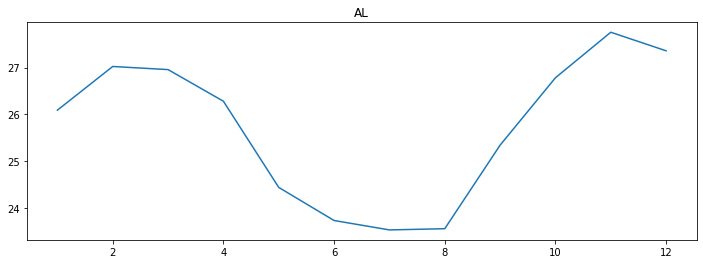

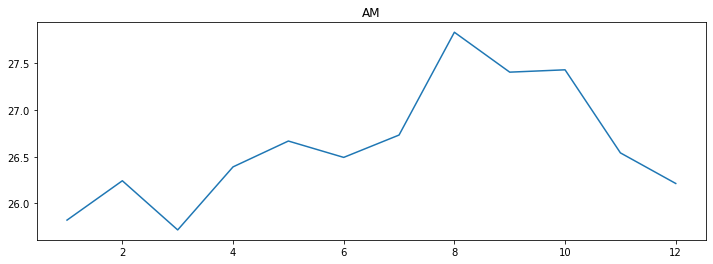

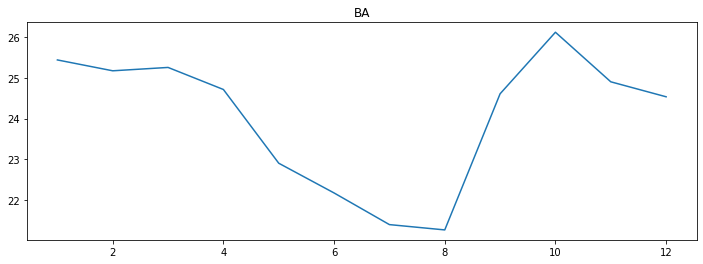

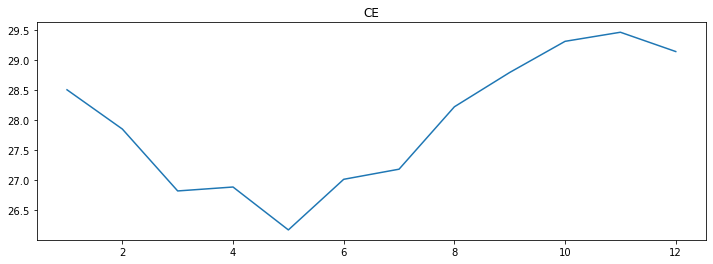

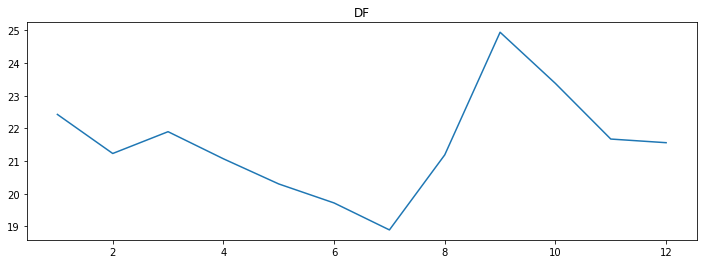

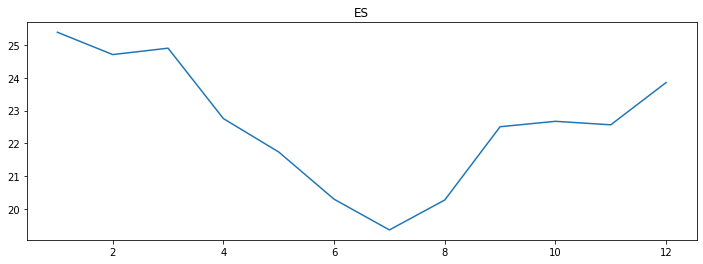

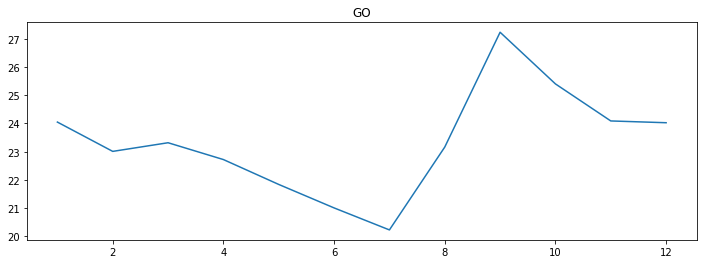

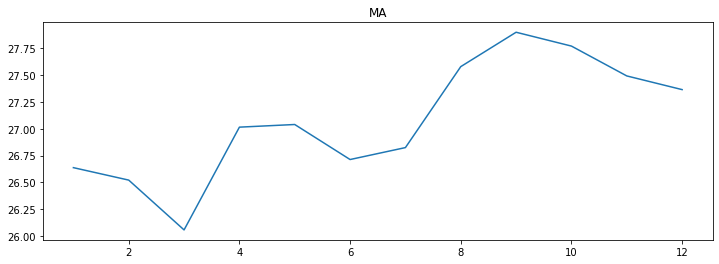

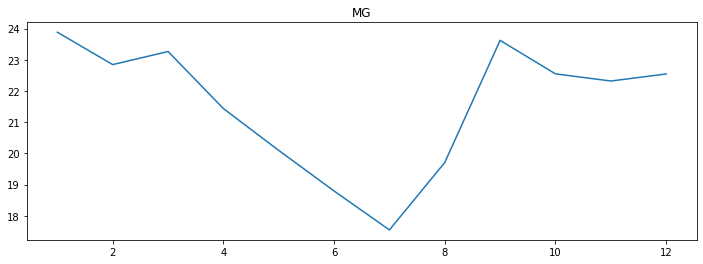

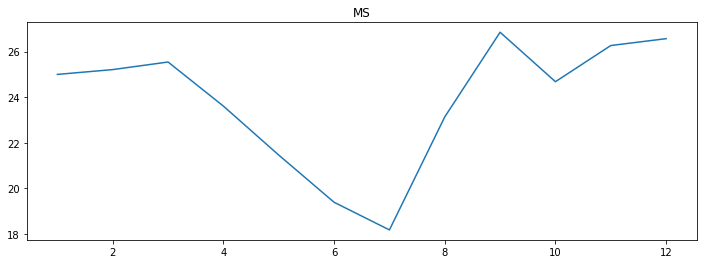

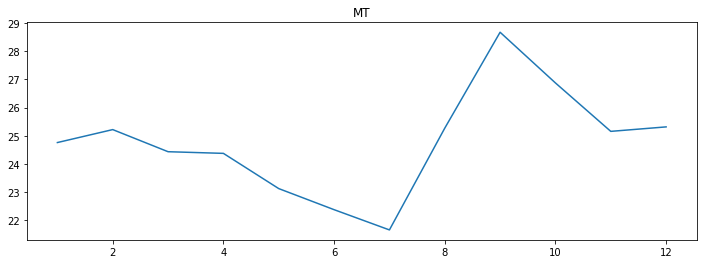

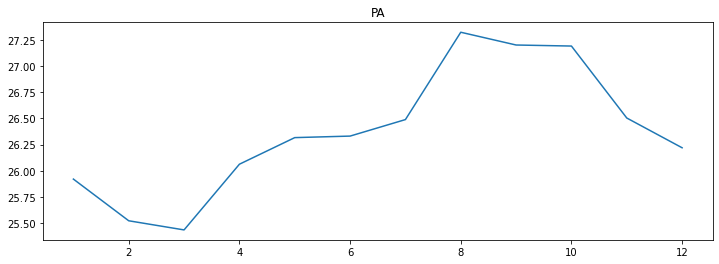

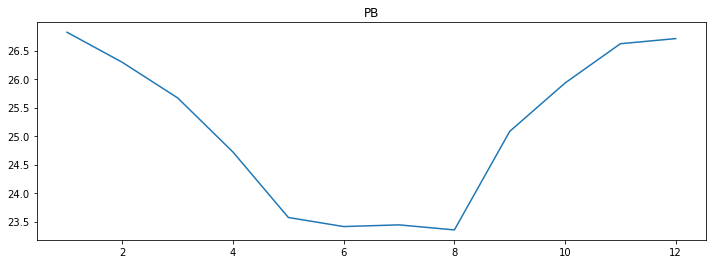

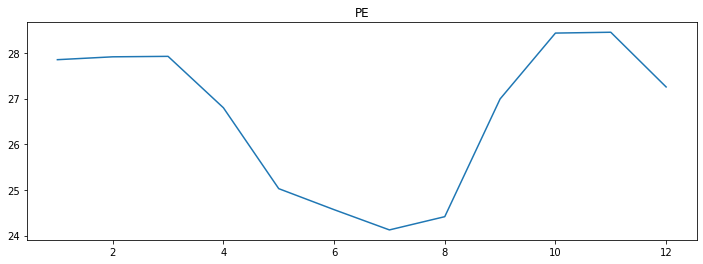

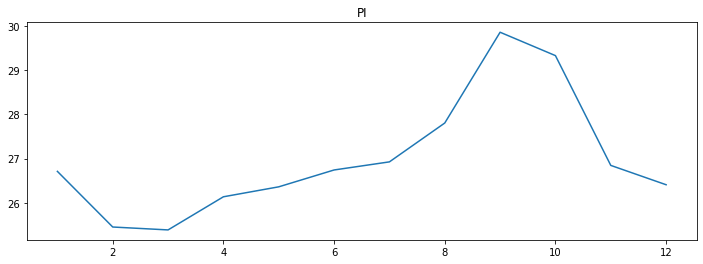

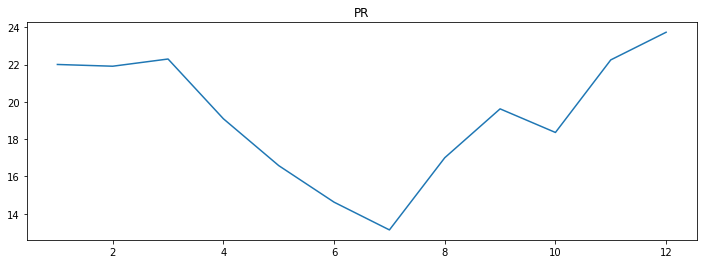

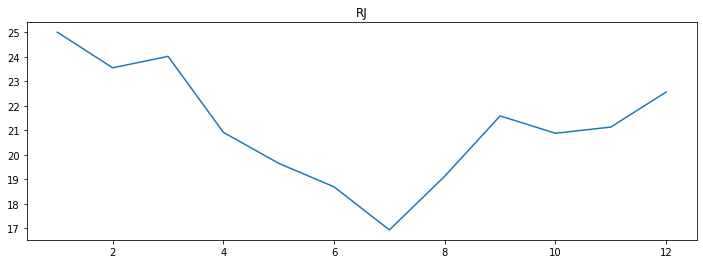

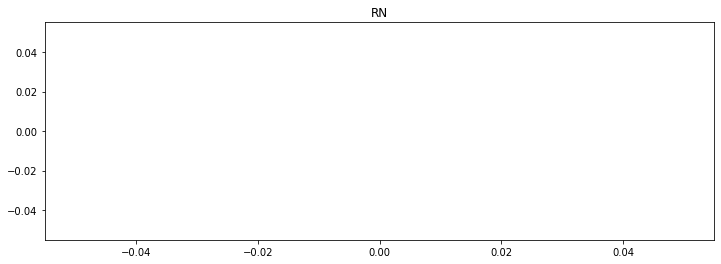

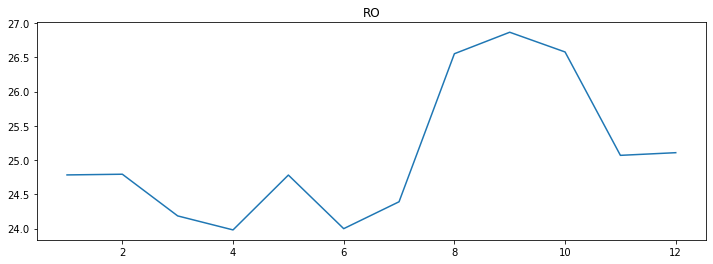

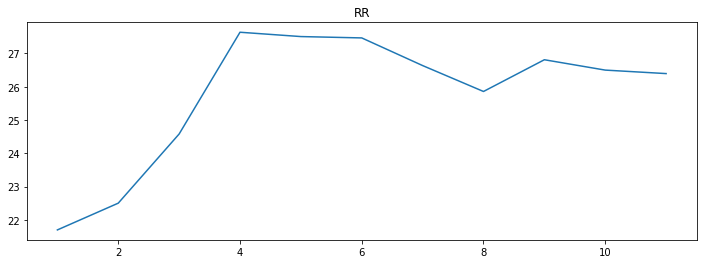

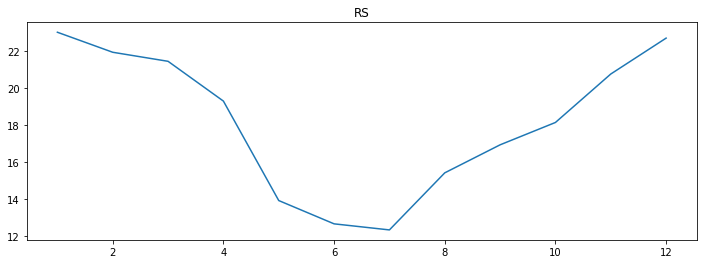

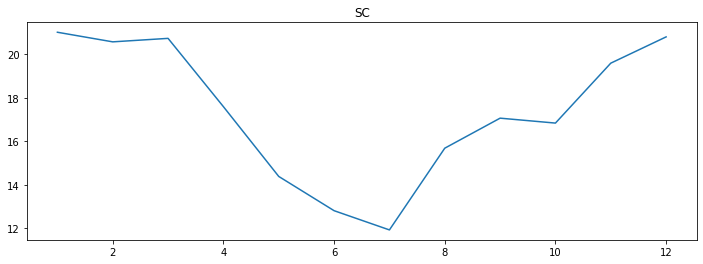

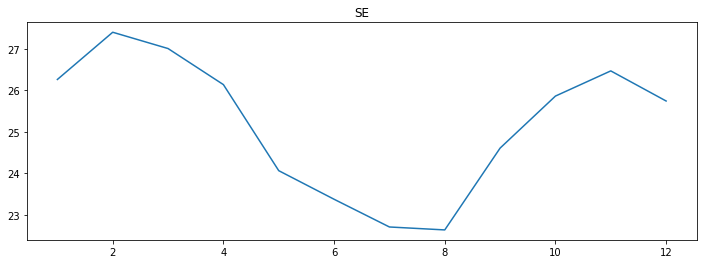

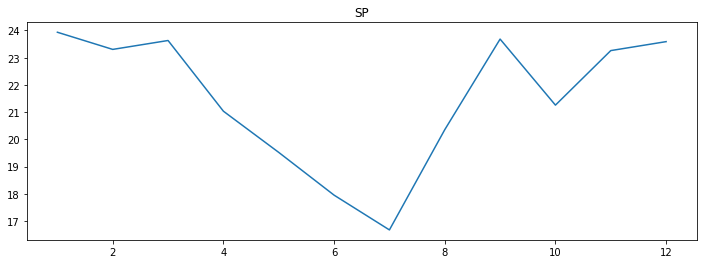

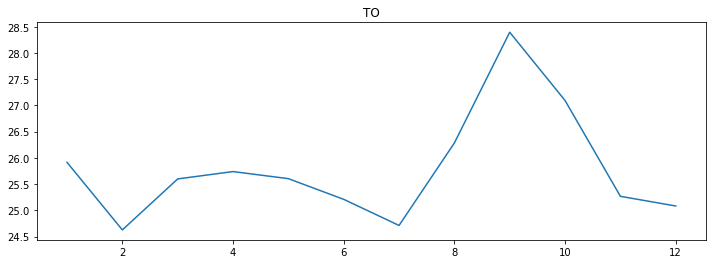

In [58]:
# list of unique states to loop through to call the function to plot average temperature per month per state:
list_states = df_historical['state'].unique().tolist()
list_states.sort()

# loop through each state:
for state in list_states:

  plot_monthly_average_temperature(state)

**Answer for question 2:**
- On the cell above, it is possible to analyse temperature month by month for each state;
- With this plots, it is very easy to understand more about the temperature of the states, which ones have more constant temperature, which ones have a big range of temperatures along the year, etc.

#### Answering question 3:
- What is the relationship between rain and temperature, considering the average from all Brazilian states? These variables are correlated somehow?

In [66]:
# checking the average temperature and rain precipitation for all states together, month by month:
df_all_brazil = df_historical.groupby('month', as_index=False).agg({
    'measure_date': ['count', 'nunique', 'min', 'max'],
    'state': ['nunique'],
    'weather_station_name': ['nunique'],
    'rain_precipitation': ['sum', 'mean', 'median', 'min', 'max'],
    'avg_temperature': ['mean', 'median', 'min', 'max']
  })

df_all_brazil.columns = df_all_brazil.columns.droplevel(0)
df_all_brazil.columns = ['month', 'number_measures', 'distinct_days', 'min_data', 'max_data', 
                         'num_states', 'num_stations',
                         'total_precipitation', 'avg_precipitation', 'median_precipitation', 'min_precipitation', 'max_precipitation',
                         'avg_temperature', 'median_temperature', 'min_temperature', 'max_temperature']

df_all_brazil.sort_values(by=['month'], ascending=True)

,month,number_measures,distinct_days,min_data,max_data,num_states,num_stations,total_precipitation,avg_precipitation,median_precipitation,min_precipitation,max_precipitation,avg_temperature,median_temperature,min_temperature,max_temperature
0,1,12400,31,2021-01-01,2021-01-31,26,397,42837.0,5.344604,0.0,0.0,130.4,24.357978,24.7,11.0,32.4
1,2,11200,28,2021-02-01,2021-02-28,26,397,53487.6,7.023057,0.2,0.0,184.0,23.659102,23.9,9.6,31.7
2,3,12400,31,2021-03-01,2021-03-31,26,397,34463.6,4.317665,0.0,0.0,144.6,23.748394,24.2,7.7,30.5
3,4,12000,30,2021-04-01,2021-04-30,26,397,18938.8,2.568321,0.0,0.0,159.8,22.206085,22.6,6.0,29.9
4,5,12400,31,2021-05-01,2021-05-31,26,397,15526.4,2.082124,0.0,0.0,157.4,20.295611,21.1,2.5,29.8
5,6,12000,30,2021-06-01,2021-06-30,26,397,14257.2,1.987343,0.0,0.0,102.0,19.134469,19.8,-4.0,29.2
6,7,12400,31,2021-07-01,2021-07-31,26,397,5882.4,0.836400,0.0,0.0,59.2,18.322553,18.7,-4.7,29.9
7,8,12400,31,2021-08-01,2021-08-31,26,397,8449.2,1.200341,0.0,0.0,99.6,20.587086,21.0,2.9,34.3
8,9,12000,30,2021-09-01,2021-09-30,26,397,14306.4,2.078814,0.0,0.0,111.4,23.427398,24.3,3.7,35.1
9,10,12400,31,2021-10-01,2021-10-31,26,397,38494.0,5.122289,0.0,0.0,198.2,22.942962,23.5,6.0,34.4


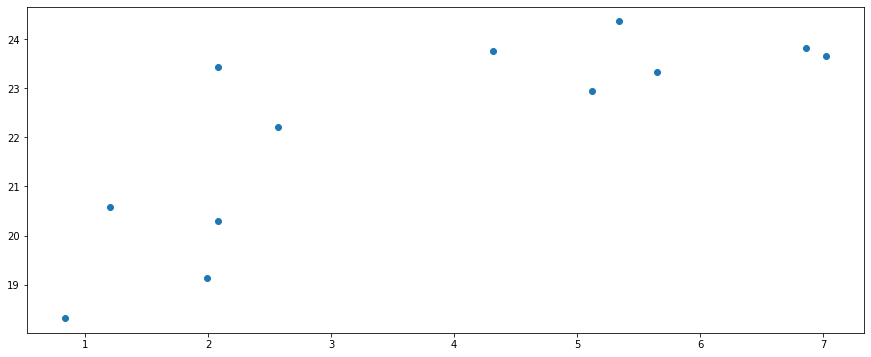

In [78]:
# plotting a scatter plot to compare rain precipitation and temperature:
plt.figure(figsize=(15, 6))
plt.scatter(data=df_all_brazil, x='avg_precipitation', y='avg_temperature');
plt.show()

# they seem to have a relationship, but not linear!!

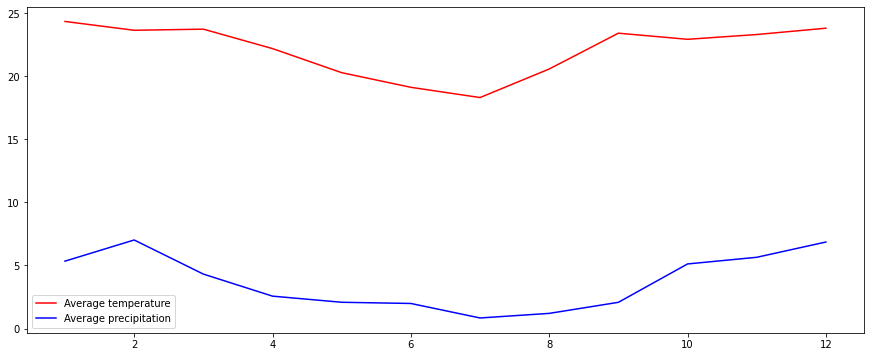

In [83]:
# now, plotting a line plot by month, with both rain and temperature:
plt.figure(figsize=(15, 6))
plt.plot(df_all_brazil['month'], df_all_brazil['avg_temperature'], c='r', label='Average temperature');
plt.plot(df_all_brazil['month'], df_all_brazil['avg_precipitation'], c='b', label='Average precipitation');
plt.legend();
plt.show()

**Answer for question 3:**
- After studing the plots above, it seems that rain and temperature are positive correlated, but not on a linear way;
- Having said that, it could be possible to train a model to find a good approximation for the non-linear correlation between both measures.

### 4 - Conclusions:

- The dataset seems to have data with good quality;
- It is possible to get a wider historical data, from other years and also from other weather stations (the manual ones) and make new analysis;
- Other weather variables are available on this dataset, such as wind velocity and humidity;
- There are information about the geographical location of each station and measurement, which could be useful to make other analysis.